<a href="https://colab.research.google.com/github/milkakeza/Formative3_Group5/blob/main/Formative3_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 3: Probability Distributions, Bayesian Probability, and Gradient Descent Implementation

# PART 1: Probability Distributions

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Download and load the skin care dataset
import kagglehub
path = kagglehub.dataset_download("najwaalsaadi/skin-care")
bp = pd.read_csv(f"{path}/skin_care.csv")

100%|██████████| 65.0k/65.0k [00:00<00:00, 44.7MB/s]

Extracting files...


In [ ]:
import math

def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    denom = 2 * math.pi * sigma_x * sigma_y * math.sqrt(1 - rho**2)
    x_term = (x - mu_x) / sigma_x
    y_term = (y - mu_y) / sigma_y
    exponent = -1 / (2 * (1 - rho**2)) * (
        x_term**2 - 2 * rho * x_term * y_term + y_term**2
    )
    return (1 / denom) * math.exp(exponent)

In [ ]:
# Display numeric columns and their correlations
numeric_cols = bp.select_dtypes(include=[np.number]).columns
print("Numeric columns:", numeric_cols.tolist())

correlation_matrix = bp[numeric_cols].corr()
print("\nCorrelation matrix:")
print(correlation_matrix)

# Find the two most correlated numeric columns
max_corr = 0
col1, col2 = None, None
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = abs(correlation_matrix.iloc[i,j])
        if corr > max_corr:
            max_corr = corr
            col1, col2 = numeric_cols[i], numeric_cols[j]

print(f"\nMost correlated columns: {col1} and {col2}")
print(f"Correlation coefficient: {correlation_matrix.loc[col1, col2]:.2f}")

Numeric columns: ['Unnamed: 0', 'price', 'stars', 'vote']

Correlation matrix:
            Unnamed: 0     price     stars      vote
Unnamed: 0    1.000000  0.112804 -0.047656  0.005391
price         0.112804  1.000000 -0.125916 -0.038107
stars        -0.047656 -0.125916  1.000000  0.107105
vote          0.005391 -0.038107  0.107105  1.000000

Most correlated columns: price and stars
Correlation coefficient: -0.13


In [ ]:
# Prepare data for bivariate normal distribution
data = bp[['price', 'stars']].values

# Calculate parameters from the data
mu_x, mu_y = np.mean(data, axis=0)
sigma_x, sigma_y = np.std(data, axis=0)
rho = np.corrcoef(data.T)[0, 1]

print("Parameters of the distribution:")
print(f"μ_price = ${mu_x:.2f}, μ_stars = {mu_y:.2f}")
print(f"σ_price = ${sigma_x:.2f}, σ_stars = {sigma_y:.2f}")
print(f"ρ = {rho:.2f}")

Parameters of the distribution:
μ_price = $44957.40, μ_stars = 3.55
σ_price = $64207.43, σ_stars = 1.83
ρ = -0.13


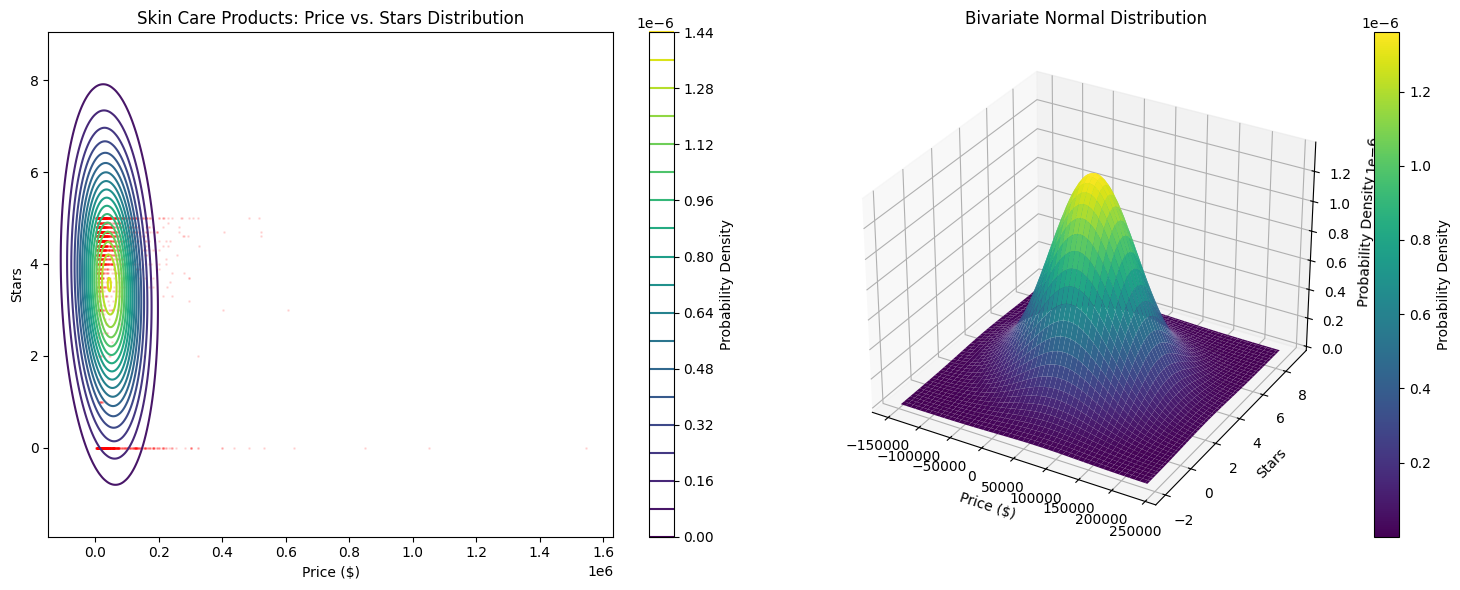

In [ ]:
# Create a grid of points
x = np.linspace(mu_x - 3*sigma_x, mu_x + 3*sigma_x, 100)
y = np.linspace(mu_y - 3*sigma_y, mu_y + 3*sigma_y, 100)
X, Y = np.meshgrid(x, y)

# Calculate PDF values for each point
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = bivariate_normal_pdf(X[i,j], Y[i,j], mu_x, mu_y, sigma_x, sigma_y, rho)

# Create subplots
fig = plt.figure(figsize=(15, 6))

# Contour plot
plt.subplot(121)
plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.scatter(data[:,0], data[:,1], c='red', alpha=0.1, s=1)
plt.xlabel('Price ($)')
plt.ylabel('Stars')
plt.title('Skin Care Products: Price vs. Stars Distribution')

# 3D surface plot
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
plt.colorbar(surf, label='Probability Density')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Stars')
ax.set_zlabel('Probability Density')
ax.set_title('Bivariate Normal Distribution')

plt.tight_layout()
plt.show()

# PART 2: Bayesian Probability

In [6]:
#Nick here is Part 2
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read data

# data = pd.read_csv('IMDB Dataset.csv', encoding='utf-8', quotechar='"')
data = pd.read_csv('IMDB Dataset.csv', encoding='utf-8', quotechar='"')

# Convert sentiment or category to numeric (positive : 1, negative : 0)
data['sentiment'] = data['sentiment'].map({'positive' : 1, 'negative' : 0})

# Keyword Selection: Choose keywords that indicate positive and keywords that indicate negative sentiments

# Positive keywords (indicate good reviews)
positive_keywords = ['loved', 'best', 'amazing', 'enjoyed']
# Negative  keywors (indicate bad reviews)
negative_keywords = ['boring', 'terrible', 'worst', 'bad']


# A function that will find Probabilities for
# Prior: P(Positive), Likelihood: P(keyword|Positive), Marginal: P(keyword), Posterior: P(Positive|keyword)
def compute_bayes(data, keyword, method_cat):
  # Method type: Positive or Negative
  if method_cat.lower() == 'positive':
    cat = 1
  elif method_cat.lower() == 'negative':
    cat = 0
  else:
    print('Method not recognised')

  # Prior
  total_reviews = len(data)
  total_category = len(data[data['sentiment'] == cat])
  p_cat = total_category/total_reviews

  # Likelihood: P(keyword|Positive)
  specific_type_data = data[data['sentiment'] == cat]
  count = 0

  for review in specific_type_data['review']:
    if keyword.lower() in review.lower().split():
      count += 1

  p_keyword_given_category = count / total_category

  # Marginal: P(keyword)
  count_whole = 0
  for review in data['review']:
    if keyword.lower() in review.lower().split():
      count_whole += 1

  p_keyword = count_whole / total_reviews

  # Posterior: P(Positive | keyword) using Bayes' theorem
  if p_keyword > 0:
    p_category_given_keyword = (p_keyword_given_category * p_cat) / p_keyword
  else:
    p_category_given_keyword = 0

  return{
      'method': method_cat,
      'Keyword': keyword,
      'P(category)': round(p_cat, 4),
      'P(keyword|category)': round(p_keyword_given_category, 4),
      'P(keyword)': round(p_keyword, 4),
      'P(Positive|keyword)': round(p_category_given_keyword, 4)
  }



In [7]:
# Compute Probabilities for positive Keywords
results_pos = []

for kw in positive_keywords:
  results_pos.append(compute_bayes(data, kw, 'positive'))

# Convert to DataFrame for easy viewing
bayes_df = pd.DataFrame(results_pos)
bayes_df

,method,Keyword,P(category),P(keyword|category),P(keyword),P(Positive|keyword)
0,positive,loved,0.5,0.0724,0.0479,0.7556
1,positive,best,0.5,0.2236,0.1691,0.6612
2,positive,amazing,0.5,0.0490,0.0322,0.7624
3,positive,enjoyed,0.5,0.0598,0.0423,0.7067


# PART3: Gradient Descent Manual Calculation

In [ ]:
# Below it the link to a neatly written document with all calculations.
url = 'https://drive.google.com/file/d/1-VlFaxbW_wmvu-TB41VjAGjq3fxYGhBl/view?usp=sharing'


Manual_calculation_pdf = https://drive.google.com/file/d/1-VlFaxbW_wmvu-TB41VjAGjq3fxYGhBl/view?usp=sharing

# PART 4: Gradient Descent in Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Sample data
X = np.array([1,3])
Y = np.array([3,6])

# Define the Mean Squared Error Function (mse)
def mse(params, X, Y):
  m, b = params
  Y_pred = m * X + b
  return np.mean((Y - Y_pred)**2)

# Define gradients
def gradient(params, X, Y):
  m,b = params
  n = len(X)
  Y_pred = m * X + b
  dm = (-2/n) * np.sum(X * (Y - Y_pred))
  db = (-2/n) * np.sum(Y - Y_pred)
  return np.array([dm, db])

# Initialize parameters
initial_params = np.array([-1,1])
learning_rate = 0.1
iterations = 4

# Track variable history
history = {'m': [], 'b': [], 'mse': []}

In [ ]:
# Callback for progress
def callback(params):
  m,b = params
  current_mse = mse(params, X, Y)
  history['m'].append(m)
  history['b'].append(b)
  history['mse'].append(current_mse)
  print(f"Iteration {len(history['m'])}: m = {m:.3f}, b = {b: .3f}, MSE = {current_mse: .3f}")

In [ ]:
# Apply SciPy optimizer
result = minimize(
    mse,
    initial_params,
    args=(X, Y),
    jac=gradient,
    method='CG',
    callback=callback,
    options={'maxiter': iterations, 'gtol': 1e-6}
)

Iteration 1: m = 1.316, b =  1.944, MSE =  0.040
Iteration 2: m = 1.500, b =  1.500, MSE =  0.000


In [ ]:
# Final Results
final_m, final_b = result.x
final_Y_pred = final_m * X + final_b
final_mse = mse(result.x, X, Y)
print("\n ✅ Optimization Completed!")
print(f"Final m = {final_m: .3f}")
print(f"Final b = {final_b: .3f}")
print(f"Final MSE = {final_mse: .3f}")
print(f"Final Predictions:", final_Y_pred)


 ✅ Optimization Completed!
Final m =  1.500
Final b =  1.500
Final MSE =  0.000
Final Predictions: [3. 6.]


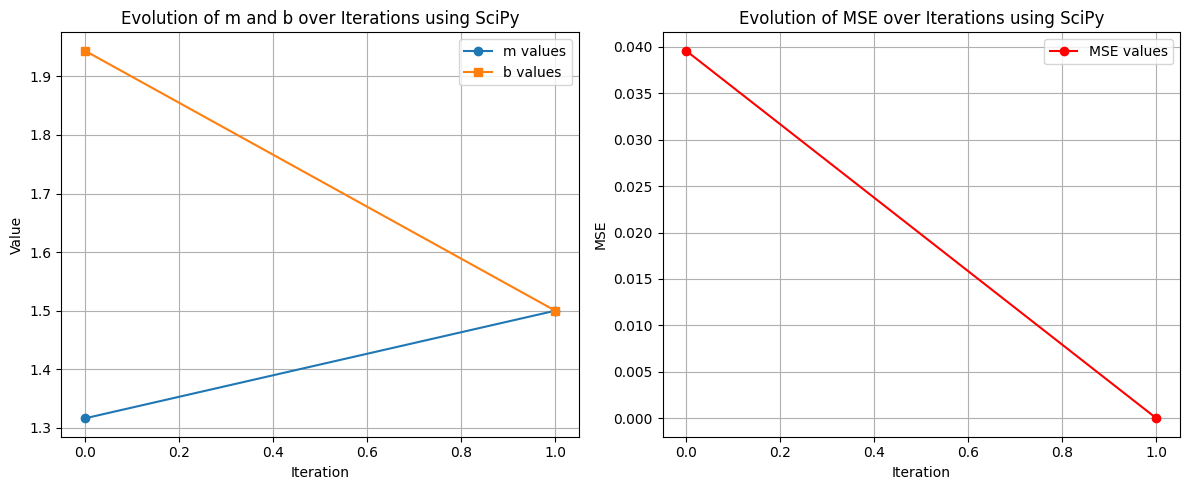

In [ ]:
# Visualization
plt.figure(figsize=(12,5))

#Plot m and b evolution over iterations
plt.subplot(1,2,1)
plt.plot(history['m'], label='m values', marker='o')
plt.plot(history['b'], label='b values', marker='s')
plt.title('Evolution of m and b over Iterations using SciPy')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot MSE over iterations
plt.subplot(1,2,2)
plt.plot(history['mse'], label='MSE values', marker='o', color='red')
plt.title('Evolution of MSE over Iterations using SciPy')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

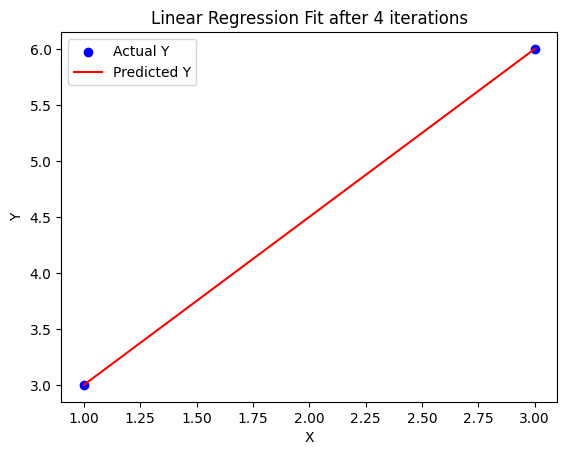

In [ ]:
# Plot final fit
plt.scatter(X, Y, color='blue', label='Actual Y')
plt.plot(X, final_Y_pred, color='red', label='Predicted Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression Fit after 4 iterations')
plt.legend()
plt.show()